# Word 2 vec basic

Создание простейшей вариации W2V в простейшей реализации (без Negative sampling)

In [1]:
# для отрисовки данных
from sklearn.decomposition import PCA 

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# все то же на торче, но с нег семплированием
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

### Загрузка данных

Возьмем набор данных твиттера 
https://study.mokoron.com/

In [4]:
pos = pd.read_csv('https://dl.uploadgram.me/60b546b286a18h?raw', encoding='utf8', sep=';', header=None)
neg = pd.read_csv('https://dl.uploadgram.me/60b54687a8eeah?raw', encoding='utf8', sep=';', header=None)

HTTPError: ignored

In [ ]:
pos.head()

In [ ]:
neg.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [ ]:
# сконкатинируем тексты, перемешаем и выберем колонку с текстами
df = pd.concat((pos, neg), axis=0).sample(frac=1).reset_index(drop=True)[3]
df.head()

0    @noona_093 судя по картинке, у тебя он проходи...
1    @Living_____Dead Ой та ладно, мога б мені напи...
2    RT @chigiryowa: Последняя серия такая трогател...
3    Из-за твоей не пунктуальности, меня скоро съедят(
4    @AnnaSamarsky даже не нервничай!) полно полезн...
Name: 3, dtype: object

In [ ]:
# многовато данных
len(df)

226834

In [ ]:
df = df[:5000]
df

0       @noona_093 судя по картинке, у тебя он проходи...
1       @Living_____Dead Ой та ладно, мога б мені напи...
2       RT @chigiryowa: Последняя серия такая трогател...
3       Из-за твоей не пунктуальности, меня скоро съедят(
4       @AnnaSamarsky даже не нервничай!) полно полезн...
                              ...                        
4995    Бляяя новый тел а уже цронила раз20 царапины н...
4996    Друзья мои, большевики отличаются своей грубос...
4997    ну а потом поняли какими пидрилками мы были и ...
4998    потом нам с Максимом грустно чуть-чуть стало(\...
4999    Дайаша уснула в зале, попыталась отнести ее на...
Name: 3, Length: 5000, dtype: object

### Случайный контекст
cгенерируем случайный контекст со стратегией выборки, описанной в оригинальной статье
https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf

In [ ]:
import string
# реализуем предобработку
def preprocess(doc):
    # к нижнему регистру
    doc = doc.lower()
    # убираем пунктуацию, пробелы, прочее
    for p in string.punctuation + string.whitespace + 'http':
        doc = doc.replace(p, ' ')
    # убираем лишние пробелы, объединяем обратно
    doc = doc.strip()
    doc = ' '.join([w for w in doc.split(' ') if w != ''])
    return doc

In [ ]:
df = df.map(preprocess)

In [ ]:
df.head()

0    noona 093 судя по картинке у тебя он проходит ...
1    living dead ой та ладно мога б мені написати в...
2    r c igiryowa последняя серия такая трогательна...
3      из за твоей не пунктуальности меня скоро съедят
4    annasamarsky даже не нервничай полно полезной ...
Name: 3, dtype: object

In [ ]:
# прогрессбар
from tqdm import tqdm

# частоты токенов
token_freq = {}

# два обратных - индексы по токенам и токены по индекса
tokens_index = []
index_tokens = {}

for i in range(len(df)):
    print(df.iloc[i])
    for word in df.iloc[i].split():
        if word in token_freq:
            token_freq[word] += 1
        else:
            # добавляем слово как новый токен и считаем кол-во вхождений
            token_freq[word] = 1
            index_tokens[word] = len(tokens_index) # номер индекса
            tokens_index.append(word) # просто добавили уникальное слово в список токенов
    print('Все токены и их частоты:', token_freq)
    print('Список всех токенов:', tokens_index)
    print('Токены и их индексы:', index_tokens)
    break

noona 093 судя по картинке у тебя он проходит весело d
Все токены и их частоты: {'noona': 1, '093': 1, 'судя': 1, 'по': 1, 'картинке': 1, 'у': 1, 'тебя': 1, 'он': 1, 'проходит': 1, 'весело': 1, 'd': 1}
Список всех токенов: ['noona', '093', 'судя', 'по', 'картинке', 'у', 'тебя', 'он', 'проходит', 'весело', 'd']
Токены и их индексы: {'noona': 0, '093': 1, 'судя': 2, 'по': 3, 'картинке': 4, 'у': 5, 'тебя': 6, 'он': 7, 'проходит': 8, 'весело': 9, 'd': 10}


In [ ]:
# прогрессбар
from tqdm import tqdm

# частоты токенов
token_freq = {}

# два обратных - индексы по токенам и токены по индекса
tokens_index = []
index_tokens = {}

for i in tqdm(range(len(df))):
    for word in df.iloc[i].split():
        if word in token_freq:
            token_freq[word] += 1
        else:
            # добавляем слово как новый токен и считаем кол-во вхождений
            token_freq[word] = 1
            index_tokens[word] = len(tokens_index) # номер индекса
            tokens_index.append(word) # просто добавили уникальное слово в список токенов


100%|██████████| 5000/5000 [00:00<00:00, 75032.81it/s]


In [ ]:
'Всего токенов', len(tokens_index)

('Всего токенов', 20262)

In [ ]:
words_count = np.array([token_freq[token] for token in tokens_index])
words_freq = words_count / np.sum(words_count)
words_freq[:5]

array([1.49934029e-05, 1.49934029e-05, 1.34940626e-04, 4.36308024e-03,
       1.49934029e-05])

In [ ]:
rej_by_index = 1 - np.sqrt(1e-5 / words_freq)
rej_by_index

array([0.18332381, 0.18332381, 0.7277746 , ..., 0.18332381, 0.18332381,
       0.18332381])

In [ ]:
# проверяем больше ли случ. чем значение по массиву отклонения индекса
check_for_reject = lambda word: np.random.rand() > rej_by_index[index_tokens[word]]    

In [ ]:
# возвращаем случайный контекст - слово и его контекст
def get_random_context(df, context_length=5):
    sentence_sampled = []
    while len(sentence_sampled) <= 2:
        sentence_index = np.random.randint(len(df)) # берем случайный индекс
        sentence = df.iloc[sentence_index].split() # по нему находим нужное предложение
        sentence_sampled = [word for word in sentence if check_for_reject(word)] # семплируем нужные слова
        
    center_word_index = np.random.randint(len(sentence_sampled)) # индекс центрального
        
    words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index] # слова до
    words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2] # слова после
        
    return sentence_sampled[center_word_index], words_before+words_after # возвращаем слово и его контекст

In [ ]:
for i in range(5):
    print(get_random_context(df))

('знакомились', ['su', 'runokg', 'конфето', 'цветочный'])
('r7w', ['хеллоуинский', 'зомбаками', '8eqz'])
('краше', ['ахахаха', 'сестренка'])
('верните', ['айфон', 'вк', 'обратно', 'было'])
('шампунь', ['была', 'волосы', 'посветлеют'])


Функция должна сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Word2vec модель получает на вход One-hot вектор слова и тренирует простую сеть для предсказания на его основе соседних слов. Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте):

Например:

Слово: orders и контекст: ['love', 'nicest', 'to', '50-year'] создадут 4 сэмпла:

* input: orders, target: love
* input: orders, target: nicest
* input: orders, target: to
* input: orders, target: 50-year

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [ ]:
class w2v_basic():
    # Аргументы: данные - твиттер 
    # datalen - количество случайных контекстов для использования при создании набора данных
    def __init__(self, data, datalen=40000):
        self.data = data
        self.datalen = datalen
        self.one_hot_df = []
    
    def generate_dataset(self):
        self.one_hot_df = []
        for _ in range(self.datalen):
            center_word, other_words = get_random_context(self.data, np.random.randint(10))
            one_hot_index = index_tokens[center_word]
            for word in other_words:
                self.one_hot_df.append((one_hot_index, index_tokens[word]))

    def __getitem__(self, index):
        '''
        Переопределим получения i-го семпла
        
        input_vector - torch.Tensor - one-hot векторная репрезентация
        output_index - индекс слова а не индекс-столбец, тк nn.crossentropy  нужен просто индек а не one-hot
        '''
        one_hot_vector = np.zeros(len(tokens_index))
        one_hot_vector[self.one_hot_df[index][0]] = 1
        return torch.Tensor(one_hot_vector), self.one_hot_df[index][1]

    # кол-во семлов
    def __len__(self):
        return len(tokens_index)
    
data = w2v_basic(df, 5)
data.generate_dataset()

In [ ]:
input_vector, target = data[3]

In [ ]:
input_vector

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [ ]:
target

7327

In [ ]:
torch.sum(input_vector) == 1.0

tensor(True)

In [ ]:
input_vector.shape[0] == len(tokens_index)

True

### Создаем модель и тренируем ее

In [ ]:
dataset = w2v_basic(df, 40000)
dataset.generate_dataset()

In [ ]:
# размерность пространства w2v - 10
dim = 10

In [ ]:
nn_model = nn.Sequential(
            nn.Linear(len(tokens_index), dim, bias=False),
            nn.Linear(dim, len(tokens_index), bias=False), 
         )

In [ ]:
nn_model.type(torch.FloatTensor)

Sequential(
  (0): Linear(in_features=20262, out_features=10, bias=False)
  (1): Linear(in_features=10, out_features=20262, bias=False)
)

In [ ]:
def word_vectors(model):
    inp = model[0].weight.data.clone()
    out = model[1].weight.data.clone()
    return torch.t(inp), out

In [ ]:
ntrained_input_vectors, untrained_output_vectors = word_vectors(nn_model)

In [ ]:
untrained_output_vectors.shape

torch.Size([20262, 10])

In [ ]:
def train_model(model, dataset, train_loader, optimizer, scheduler, num_epochs):
    # Тренируем w2v модель используя в качестве лосса кросс-энтропию, создавая новый набор данных на каждой эпохе
    
    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
    loss_history = []
    train_history = []
    for epoch in range(num_epochs):
        model.train()
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        scheduler.step()
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value.item()
            
        avg_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        loss_history.append(float(avg_loss))
        train_history.append(train_accuracy)
        dataset.generate_dataset()

        print(f'Epoch {epoch}, Average loss: {avg_loss}, Train accuracy: {train_accuracy}')
    return loss_history, train_history

In [ ]:
dataset[0]

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), 13639)

In [ ]:
optimizer = optim.SGD(nn_model.parameters(), lr=5, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.5)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)
loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 40)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 0, Average loss: 9.921554315007803, Train accuracy: 0.0013818971473694602
Epoch 1, Average loss: 9.913055965013118, Train accuracy: 0.002023492251505281
Epoch 2, Average loss: 9.902164318954604, Train accuracy: 0.003109268581581285
Epoch 3, Average loss: 9.88609798804205, Train accuracy: 0.003257328990228013
Epoch 4, Average loss: 9.867057920796732, Train accuracy: 0.002615733886092192
Epoch 5, Average loss: 9.843238341019866, Train accuracy: 0.0026650873556411016
Epoch 6, Average loss: 9.801313641276082, Train accuracy: 0.0027637942947389203
Epoch 7, Average loss: 9.745598227226958, Train accuracy: 0.0036521567466192874
Epoch 8, Average loss: 9.670077370985357, Train accuracy: 0.0039976310334616525
Epoch 9, Average loss: 9.590054607108927, Train accuracy: 0.004392458789852926
Epoch 10, Average loss: 9.494359408055688, Train accuracy: 0.0068601322672983914
Epoch 11, Average loss: 9.401085380505245, Train accuracy: 0.009821340440232949
Epoch 12, Average loss: 9.303333886401674, Tr

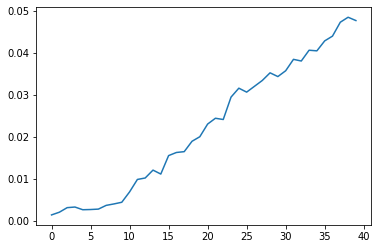

In [ ]:
plt.plot(train_history)

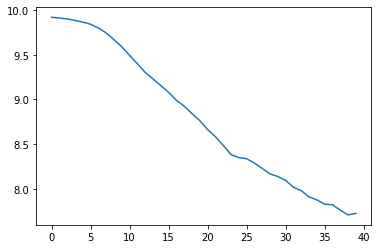

In [ ]:
plt.plot(loss_history)

В случае успешной тренировки можно посмотреть, как вектора слов разных типов разделяются семантически.

In [ ]:
trained_input_vectors, trained_output_vectors = word_vectors(nn_model)

wordvec_embedding = PCA(n_components=2).fit_transform(torch.cat((trained_input_vectors, trained_output_vectors), 0))

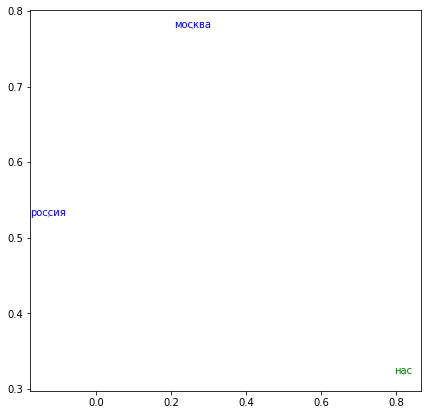

In [ ]:
words_to_viz = {'green': ['нас', ], 'blue': ['россия', 'москва']}

plt.figure(figsize=(7,7))
for color, words in words_to_viz.items():
    points = np.array([wordvec_embedding[index_tokens[w]] for w in words])
    for i, word in enumerate(words):
        plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
    plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

## Готовые решения

In [ ]:
!pip install navec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2022-11-17 17:47:56--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  16.0MB/s    in 3.3s    

2022-11-17 17:48:00 (15.2 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [ ]:
from navec import Navec
navec = Navec.load('/content/navec_hudlit_v1_12B_500K_300d_100q.tar')

In [ ]:
navec.vocab.word_ids

{'a': 0,
 'a-а': 1,
 'aa': 2,
 'aaa': 3,
 'aan': 4,
 'aaron': 5,
 'aazen': 6,
 'ab': 7,
 'abandon': 8,
 'abandoned': 9,
 'abb': 10,
 'abba': 11,
 'abbey': 12,
 'abbiamo': 13,
 'abbot': 14,
 'abbott': 15,
 'abbyy': 16,
 'abc': 17,
 'abel': 18,
 'abend': 19,
 'aber': 20,
 'abhandlungen': 21,
 'abilities': 22,
 'ability': 23,
 'able': 24,
 'abnormal': 25,
 'aboard': 26,
 'abord': 27,
 'about': 28,
 'above': 29,
 'abraham': 30,
 'abroad': 31,
 'abruptly': 32,
 'abs': 33,
 'absence': 34,
 'absent': 35,
 'absolute': 36,
 'absolutely': 37,
 'absorbed': 38,
 'abstract': 39,
 'absurd': 40,
 'absurdum': 41,
 'abt': 42,
 'abteilung': 43,
 'abu': 44,
 'abuela': 45,
 'abuse': 46,
 'aby': 47,
 'ac': 48,
 'acad': 49,
 'academia': 50,
 'academic': 51,
 'academie': 52,
 'academy': 53,
 'acc': 54,
 'accent': 55,
 'accept': 56,
 'acceptance': 57,
 'accepted': 58,
 'accepting': 59,
 'access': 60,
 'accident': 61,
 'accompanied': 62,
 'accompany': 63,
 'accompli': 64,
 'accomplish': 65,
 'accomplished': 66

In [ ]:
nav

['__attributes__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_repr_pretty_',
 'as_gensim',
 'dump',
 'get',
 'load',
 'meta',
 'pq',
 'sampled',
 'sim',
 'vocab']

In [ ]:
!wget http://vectors.nlpl.eu/repository/20/220.zip

In [ ]:
navec.get('привет')

array([-0.14197442,  0.01595282, -0.11622857,  0.19758469, -0.54093564,
       -0.23015393,  0.2083324 ,  0.20733036, -0.46802008, -0.43609178,
       -0.12699111,  0.11630419, -0.25389975, -0.2675142 ,  0.32111672,
        0.09095071, -0.31486326, -0.23365863, -0.1914287 , -0.2472466 ,
       -0.35027468, -0.02377667, -0.49100557,  0.7579114 ,  0.43025348,
        0.33716568, -0.30256617, -0.31430617, -0.7097412 , -0.19473657,
       -0.20919581, -0.3833087 ,  0.15386088,  0.28161135,  0.09251209,
        0.15977159, -0.04214252,  0.23746091,  0.37219337,  0.07557444,
       -0.06280387, -0.32926294,  0.4910019 , -0.48998028, -0.36470553,
        0.02416045,  0.00712121,  0.07632633, -0.36364338, -0.05238971,
        0.28933373,  0.3203861 ,  0.3046747 ,  0.36945623,  0.5994971 ,
       -0.17325711, -0.31948823,  0.2167263 ,  0.7109235 ,  0.6527332 ,
        0.16617548, -0.64993405,  0.4042312 , -0.12316786,  0.37892154,
        0.24959418,  0.26957294,  0.36229745, -0.49809262, -0.31

## W2V negative sampling

In [ ]:
from sklearn.utils import shuffle

class w2v_neg_sample(Dataset):
    # Аргументы: данные - твиттер 
    # datalen - количество случайных контекстов для использования при создании набора данных
    def __init__(self, data, neg_sample, datalen=40000):
        self.data = data
        self.datalen = datalen
        self.one_hot_df = []
        self.neg_samples = neg_sample
        # print(self.neg_samples)

    def generate_dataset(self):
        self.one_hot_df = []
        for _ in range(self.datalen):
            center_word, other_words = get_random_context(self.data, np.random.randint(self.neg_samples))
            one_hot_index = index_tokens[center_word]
            for word in other_words:
                random_samples = []
                random_samples.append(index_tokens[word])
                for temp in range(self.neg_samples):
                    neg_word, _ = get_random_context(self.data, np.random.randint(2))
                    random_samples.append(index_tokens[neg_word])
                self.one_hot_df.append((one_hot_index, random_samples))

    def __getitem__(self, index):
        '''
        Переопределим получения i-го семпла
        
        input_vector - torch.Tensor - one-hot векторная репрезентация
        output_index - индекс слова 
        '''

        input_index, output_indexes = self.one_hot_df[index]
        output = np.zeros_like(output_indexes)
        output[0] = 1
        output_index, output = shuffle(output_indexes, output)
        # на выход подаем
        # индекс входного слова
        # тензор индексов таргет значений 
        # тензор для обучения - 1 где верный ответ и 0 для каждого элемента из one_hot_df - массив negative sampling-a
        return input_index, torch.Tensor(output_indexes), torch.Tensor(output)

    # кол-во семлов
    def __len__(self):
        return len(self.one_hot_df)

data_gen = w2v_neg_sample(df, 20, 5)
data_gen.generate_dataset()

In [ ]:
input_vector, output_indexes, target = data_gen[3]

In [ ]:
input_vector

1168

In [ ]:
output_indexes

tensor([ 1167., 11560.,  4219.,  4361., 17736.,  6887.,  7817., 17226., 17114.,
        20051., 16411., 17692.,  4496.,  1997.,  1713.,   376., 17632.,  6274.,
         2254.,  7134.,  3142.])

In [ ]:
len(output_indexes) # 20 негативных, от которых отталкиваемся + 1 верный

21

In [ ]:
target

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0.])

In [ ]:
len(target)

21

## Создание модели w2v для негативного семплировния

In [ ]:
class w2v_neg_sample_train(nn.Module):
    def __init__(self, token_num):
        super(w2v_neg_sample_train, self).__init__()

        self.input = nn.Linear(token_num, 10, bias=False)
        self.output = nn.Linear(10, token_num, bias=False)

    # прямой проход по данным, получаем на вход индекс входного слова и набор индексов для выходных слов
    def forward(self, inp_index, out_index):
        preds = torch.cuda.FloatTensor([])
        # проходимся по батчам и их индексам
        for i, input_index in enumerate(inp_index):
            result = torch.cuda.FloatTensor(out_index.shape[1])
            inp_weights = self.input.weight[:, input_index]
            # проходимся по выходам
            for ind, output_index in enumerate(out_index[i]):
                out_weights = self.output.weight[int(output_index)]
                # скалярно перемножаем веса входные и выходные
                result[ind] = torch.dot(inp_weights, out_weights)
            # приводим к нужному размерну
            result = torch.reshape(result, (1, len(result)))
            preds = torch.cat((preds, result), 0) # конкратинация для нужного числа измерений
        return preds            

NN = w2v_neg_sample_train(len(tokens_index))
NN.type(torch.cuda.FloatTensor)

w2v_neg_sample_train(
  (input): Linear(in_features=20262, out_features=10, bias=False)
  (output): Linear(in_features=10, out_features=20262, bias=False)
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
NN.to(device)

w2v_neg_sample_train(
  (input): Linear(in_features=20262, out_features=10, bias=False)
  (output): Linear(in_features=10, out_features=20262, bias=False)
)

In [ ]:
def word_vectors(model):
    # немного поменял способ доступа к данным, тупо получаем веса
    inp = model.input.weight.data.clone()
    out = model.output.weight.data.clone()
    return torch.t(inp), out

## Обучение модели

In [ ]:
def train_w2v_neg(model, dataset, train_loader, optimizer, scheduler, num_epochs):
    # стабильнее классической сигмоиды
    # https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
    loss = nn.BCEWithLogitsLoss().type(torch.cuda.FloatTensor)

    loss_history = []
    train_history = []
    
    for epoch in range(num_epochs):
        model.train()
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        

        for i_step, (to , x, y) in enumerate(train_loader):
            to_gpu = to.to(device)
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(to_gpu, x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            temp, indexes = torch.max(prediction, 1)
            temp, indexes_y = torch.max(y_gpu, 1)
            correct_samples += torch.sum(indexes == indexes_y)
            total_samples += indexes_y.shape[0]
            
            loss_accum += loss_value
        
        scheduler.step()
        
        avg_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        loss_history.append(float(avg_loss))
        train_history.append(train_accuracy)

        dataset.generate_dataset()
        print(f'Epoch {epoch}, Average loss: {avg_loss}, Train accuracy: {train_accuracy}')
        
    return loss_history, train_history

In [ ]:
data_gen = w2v_neg_sample(df, 20, 40000)
data_gen.generate_dataset()

In [ ]:
optimizer = optim.Adam(NN.parameters(), lr=5, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

train_loader = torch.utils.data.DataLoader(data_gen, batch_size=40)

In [ ]:
loss_history, train_history = train_w2v_neg(NN, data_gen, train_loader, optimizer, scheduler, 40)

KeyboardInterrupt: ignored